In [15]:
import foldrpp
from itertools import product
import cv2
import numpy as np
import matplotlib.pyplot as  plt
from scipy import ndimage

In [16]:
def non_maximum_suppression(R):
    mask = np.zeros(R.shape)
    h = R.shape[0]
    w = R.shape[1]
    d_list = [[-1, -1], [-1, 0], [-1, +1],
              [0, -1], [0, +1],
              [+1, -1], [+1, 0], [+1, +1]]

    for i in range(0,int(R.shape[0])):
        for j in range(0,int(R.shape[1])):
            flag = True
            for d in d_list:
                ni, nj = (i + d[0], j + d[1])
                if (0 <= ni < h) and (0 <= nj < w):
                    if (R[ni, nj] >= R[i, j]):
                        flag = False
            if flag:
                mask[i,j] = 1
            else:
                mask[i,j] = 0

            if(R[i-1,j-1] < R[i,j] and R[i,j-1] < R[i,j] and R[i-1,j] < R[i,j] and R[i+1,j] < R[i,j]
            and R[i-1,j+1] < R[i,j] and R[i,j+1] < R[i,j] and R[i+1,j+1] < R[i,j] and R[i+1,j-1] < R[i,j]):
                mask[i,j] = 1
            else:
                mask[i,j] = 0
    return mask

In [17]:
def harris_corner(im):
    # step 0: convert RGB to gray-scale image
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    gray_1 = np.copy(gray)
    gray_1 = np.float32(gray_1)

    # step 1: compute image gradient using Sobel filters
    # https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html
    sobelx = cv2.Sobel(gray_1, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray_1, cv2.CV_64F, 0, 1, ksize=5)
    
    # step 2: compute products of derivatives at every pixels
    IXX = np.square(sobelx)
    IYY = np.square(sobely)
    IXY = np.multiply(sobelx, sobely)


    # step 3: compute the sums of products of derivatives at each pixel using Gaussian filter from OpenCV
    gaussian = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]]) / 16
    X_filter = cv2.filter2D(IXX, cv2.CV_64F, gaussian)
    Y_filter = cv2.filter2D(IYY, cv2.CV_64F, gaussian)
    XY_filter = cv2.filter2D(IXY, cv2.CV_64F, gaussian)

    # step 4: compute determinant and trace of the M matrix
    det = X_filter * Y_filter - (XY_filter ** 2)
    trace = (X_filter + Y_filter)

    # step 5: compute R scores with k = 0.05
    k = 0.04
    R = det - k * (np.square(trace))

    # step 6: thresholding
    # up to now, you shall get a R score matrix with shape [height, width]
    threshold = 0.01 * R.max()
    R[R < threshold] = 0

    # step 7: non-maximum suppression
    corner_mask = non_maximum_suppression(R)

    return corner_mask

In [18]:
im = cv2.imread(r"img/bicycle.bmp")

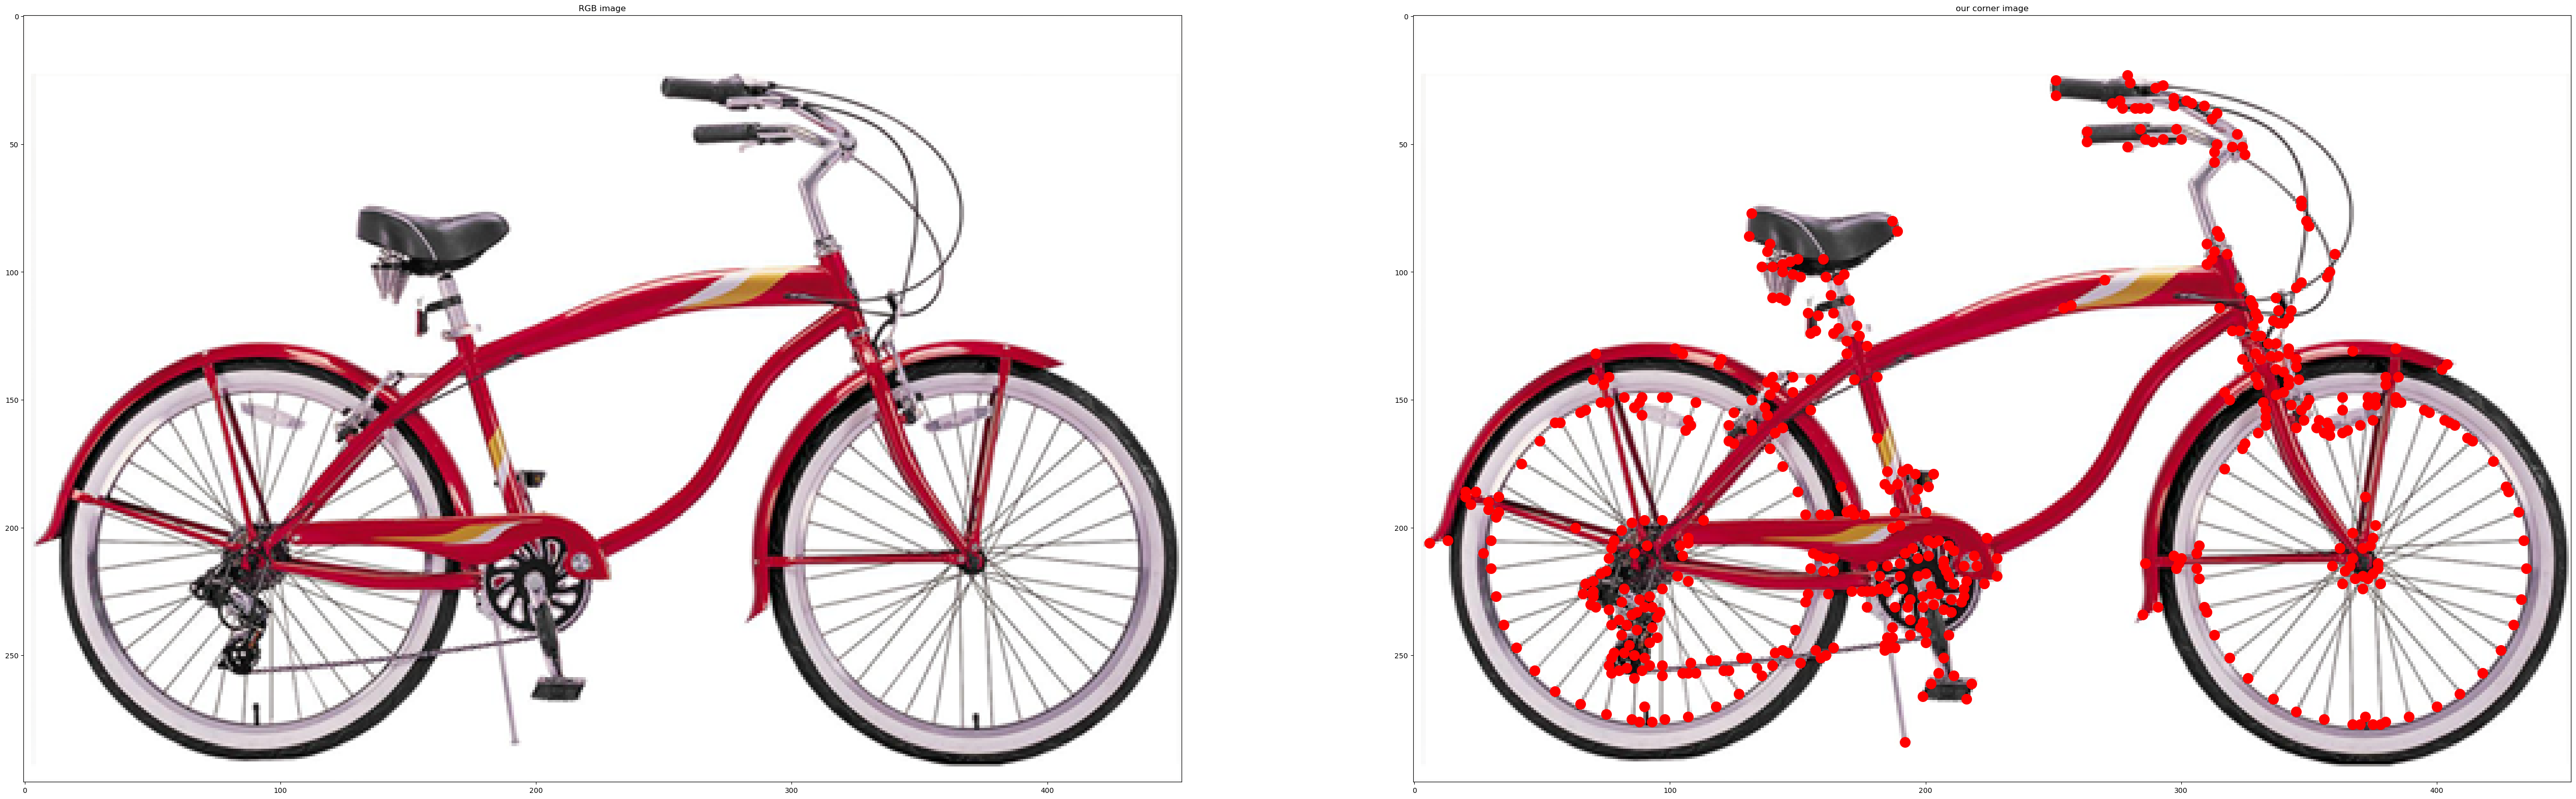

In [19]:
corner_mask = harris_corner(im)

# opencv harris corner
img = im.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

# visualization for your debugging
fig = plt.figure(figsize = (100,50))

# show RGB image
ax = fig.add_subplot(1, 3, 1)
plt.imshow(im[:, :, (2, 1, 0)])
ax.set_title('RGB image')

# show our corner image
ax = fig.add_subplot(1, 3, 2)
plt.imshow(im[:, :, (2, 1, 0)])
index = np.where(corner_mask > 0)
plt.scatter(x=index[1], y=index[0], c='red', s=200)
ax.set_title('our corner image')
plt.savefig("compare2.png",dpi=300)
plt.show()